# Predicting Molecular Activity Using Deep Learning in Tensorflow
This work provides a solution of the Merck Molecular Activity Kaggle Challenge (https://www.kaggle.com/c/MerckActivity) using deep learning with the TensorFlow library.

## Problem Description
Predicting the activity of a novel compound is a real challenge encountered in pharmaceutical companies when developing new drugs. During the drug discovery process, it is standard practice to scan a large library of compounds to test their biological activity towards both the intended target molecule as well as peripheral off-target molecules. It is desirable for a compound to be highly specific in order to have high efficacy and minimize side effects – that is, it should be highly active against the target molecule while showing low or no activity towards off-target molecules. This process can be very time-consuming and expensive. It is therefore desirable to quantitatively predict such biological activity between compounds and both target and off-target molecules. Such predictions can help prioritize experiments and reduce the experimental work that needs to be performed. Indeed, such predictions are called Quantitative structure−activity relationships (QSAR) and are very commonly used in the pharmaceutical industry. 
The QSAR method has the following characteristics:
- 1) The data set in an pharmaceutical environment usually involves a large library of compounds. For example, each target is tested against over 20,000 compounds in this Merck data challenge.
- 2) Each compound is usually represented by a list of features or fingerprint descriptors. These fingerprints typically describe the content, chemistry, and molecular topology of the molecule and are encoded by a feature vector. For example, content and chemistry can include descriptors for the number of carbon and nitrogen atoms, hydrogen-bonding donors and acceptors, charges, polar and nonpolar atoms, and functional groups (ketone, carboxylic acid, etc). The topology includes which atoms are bonded to which other atoms within a specific radius (i.e. a subgraph of the molecular graph). The Merck challenge as described on the Kaggle does not give the specific fingerprints used, only the feature vectors as raw data.
- 3) Each set of compounds may involve a total number of thousands of fingerprint descriptors. Therefore, the vectors describing each compound are sparse and only a small proportion of them are nonzero.
- 4) These descriptors are not all independent. Depending on the structure of the compound, strong correlations may exist between different descriptors.


#### Objective & Data
The objective of this Merck data challenge is to identify the best statistical techniques for predicting biological activities of compounds against specific molecules given the numerical descriptors generated from the chemical structures of these compounds.

The data provided by Merck is based on 15 target molecules and over 10,000 compounds for each target. For each target molecule, each row of the data corresponds to a compound and contains descriptors derived from that compound's chemical structure. Activity between the target molecule and each compound is provided in the training data and is the target for prediction in the test data.

#### Evaluation Metric
Predictions for activity will be evaluated using the correlation coefficient R2, averaged over the 15 data sets.
![Splitting using a single line](Evaluation Metric.JPG)
where x is the known activity, x¯ is the mean of the known activity, y is the predicted activity, y¯ is the mean of the predicted activity, and Ns is the number of molecules in data set s.

Sample code has been provided to calculate r-squared.

## Approaches and Solutions
Given that the target variable activity is continuous and each dataset contains tens of thousands of entries, this is a regression problem and I will build a neural network(NN) using the TensorFlow library in Python to make predictions. The cost function is defined as mean squared error or MSE in this work.

## Part I. Preliminary Data Analysis

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
train_1 = pd.read_csv('TrainingSet/ACT1_competition_training.csv', dtype={"MOLECULE": object, "Act": float})

In [3]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37241 entries, 0 to 37240
Columns: 9493 entries, MOLECULE to D_11078
dtypes: float64(1), int64(9491), object(1)
memory usage: 2.6+ GB


In [4]:
train_1.head(5)

,MOLECULE,Act,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_11,...,D_11061,D_11064,D_11065,D_11066,D_11067,D_11068,D_11070,D_11074,D_11076,D_11078
0,ACT1_M_80,6.0179,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACT1_M_189,4.3003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACT1_M_190,5.2697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACT1_M_402,6.1797,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACT1_M_659,4.3003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_1 = train_1.dropna(axis = 1) # drop all columns that contain null value

In [6]:
train_1.head(5)

,MOLECULE,Act,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_11,...,D_11061,D_11064,D_11065,D_11066,D_11067,D_11068,D_11070,D_11074,D_11076,D_11078
0,ACT1_M_80,6.0179,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACT1_M_189,4.3003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACT1_M_190,5.2697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACT1_M_402,6.1797,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACT1_M_659,4.3003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There is no missing values in train_1.

In [7]:
train_1.describe()

,Act,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_11,D_15,...,D_11061,D_11064,D_11065,D_11066,D_11067,D_11068,D_11070,D_11074,D_11076,D_11078
count,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,...,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000,37241.000000
mean,4.690458,0.000081,0.000054,0.000430,0.000107,0.000027,0.000081,0.000242,0.000054,0.000027,...,0.000027,0.000027,0.000081,0.000215,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027
std,0.648661,0.015546,0.010364,0.020723,0.010363,0.005182,0.008975,0.015544,0.007328,0.005182,...,0.005182,0.005182,0.008975,0.014655,0.005182,0.005182,0.005182,0.005182,0.005182,0.005182
min,4.300300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.300300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.903300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.134000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The mean of all columns except the target column 'Act' are all very small, indicating the descriptor vectors are all very sparse.

Let's take a look at some other training data.

In [8]:
train_2 = pd.read_csv('TrainingSet/ACT2_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
train_4 = pd.read_csv('TrainingSet/ACT4_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
train_6 = pd.read_csv('TrainingSet/ACT6_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
train_8 = pd.read_csv('TrainingSet/ACT8_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
train_10 = pd.read_csv('TrainingSet/ACT10_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
train_12 = pd.read_csv('TrainingSet/ACT12_competition_training.csv',dtype={"MOLECULE": object, "Act": float})

In [9]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8716 entries, 0 to 8715
Columns: 5879 entries, MOLECULE to D_11072
dtypes: float64(1), int64(5877), object(1)
memory usage: 390.9+ MB


In [10]:
train_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Columns: 4308 entries, MOLECULE to D_10772
dtypes: float64(1), int64(4306), object(1)
memory usage: 59.7+ MB


In [11]:
train_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37388 entries, 0 to 37387
Columns: 8923 entries, MOLECULE to D_11081
dtypes: float64(1), int64(8921), object(1)
memory usage: 2.5+ GB


In [12]:
train_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965 entries, 0 to 9964
Columns: 5805 entries, MOLECULE to D_11054
dtypes: float64(1), int64(5803), object(1)
memory usage: 441.3+ MB


In [13]:
train_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11151 entries, 0 to 11150
Columns: 5792 entries, MOLECULE to D_11070
dtypes: float64(1), int64(5790), object(1)
memory usage: 492.8+ MB


Different training data have different dimensions, corresponds to different number of off-target molecules and descriptors. ***Given the limited computing power of the PC I am using, I will focus on training neural networks for the first training data.***

In [14]:
test_1 = pd.read_csv('TestSet/ACT1_competition_test.csv',dtype={"MOLECULE": object} )
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12338 entries, 0 to 12337
Columns: 9492 entries, MOLECULE to D_11078
dtypes: int64(9491), object(1)
memory usage: 893.5+ MB


In [15]:
test_1.head(5)

,MOLECULE,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_11,D_15,...,D_11061,D_11064,D_11065,D_11066,D_11067,D_11068,D_11070,D_11074,D_11076,D_11078
0,ACT1_M_79,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACT1_M_454,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACT1_M_3032,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACT1_M_3612,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACT1_M_3616,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Compared to the training data, the test data misses the 'Act' column, which is the target value in this work.

The descriptors in the test set, similar to those in the training set, are also quite sparse. ***Given that there is no way to know the prediction accuracy on the testing data, I split the training data into two parts (train/test) for the following model optimization and prediction.***

## Part II. Machine Learning

### 1. Data Preprocessing
I'll first removing features with variance below a threshold (8e-5) to eliminate descriptors containing too little information. That way, some useful information will be removed from the training data, but may also prevent overfitting. 

In [27]:
def preprocessing(df, threshold):
    """remove columns in df with zero variances
    """
    col_num = len(df.iloc[0, :])
    col_name = []
    for i in range(2, col_num):
        s = df.iloc[:, i]
        if s.std() < threshold:
            col_name.append(df.columns[i])
    df = df.drop(col_name, axis = 1)
    new_col_num = len(df.iloc[0, :])
    pct = (1 - new_col_num*1.0/col_num)*100
    print('{:.2f}% of features were removed.'.format(pct))
    return df

In [28]:
train_1 = preprocessing(train_1, 5e-4)

3.31% of features were removed.


The above preprocessing is used in the trial period but not used in the final optimized model.

Logarithmic transformation y = log(x+1)

Alternatively, either no transformation or binary transformation can be used. Logarithmic transformation performs best though.

In [114]:
import numpy as np
y = train_1['Act'].values
y = np.reshape(y, (-1, 1))
train_1 = train_1.drop(['Act', 'MOLECULE'], axis = 1)
train_1 = train_1.apply(lambda x: np.log(x+1))
x = train_1_norm.values

(array([25398.,  4242.,  3099.,  1821.,  1117.,   639.,   343.,   363.,
          177.,    42.]),
 array([4.3003 , 4.68367, 5.06704, 5.45041, 5.83378, 6.21715, 6.60052,
        6.98389, 7.36726, 7.75063, 8.134  ]),
 <a list of 10 Patch objects>)

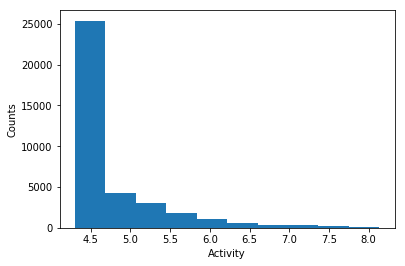

In [34]:
y_new = (y - np.mean(y))/np.std(y)
print(y_new, y)
plt.xlabel('Activity')
plt.ylabel('Counts')
plt.hist(y)

Split train data into train/test part (80:20)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size = 0.80)

There are 29792 entries for training the model and 7448 entries for model testing. This split gurantees there's enough data for both the training and testing steps.

### 2. Define evaluation metric r^2

In [117]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

### 3. Train neural network

#### 1) Optimized NN with two hidden layers

In [ ]:
sys.stdout.write( "reading data ... ")
sys.stdout.flush()
start = datetime.datetime.now()
train_1 = pd.read_csv('TrainingSet/ACT1_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
stop = datetime.datetime.now()
sys.stdout.write( "done\n")
sys.stdout.write( "took {} seconds\n".format( ( stop - start ).total_seconds() ) )
sys.stdout.flush()

y = train_1['Act'].values
y = np.reshape(y, (-1, 1))
train_1 = train_1.drop(['Act', 'MOLECULE'], axis = 1)
#train_1 = train_1.apply(lambda x: 1 if x > 0 else 0)
#x = train_1.values
x = np.where(train_1 > 0, 1, 0)

seed = round(random.uniform(1, len(x)))
X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

X_placeholder = tf.placeholder(tf.float32, (None, X_train.shape[1]))
Y_placeholder = tf.placeholder(tf.float32, (None, Y_train.shape[1]))

# define parameters
features = np.shape(X_train)[1] # switch to X_train
target_size = np.shape(X_train)[0]

learning_rate = 0.001# switch to 0.05

epochs = 900
batch_size = 300

batch_size_placeholder = tf.placeholder(tf.int64)

# network parameters
n_hidden_1 = 100
n_hidden_2 = 50

ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )

ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)

next_x, next_y = ds_iter.get_next()

train_init_op = ds_iter.make_initializer(ds_train)
test_init_op = ds_iter.make_initializer(ds_test)

# define placeholder for input vector X and target vector y
keep_prob = tf.placeholder(tf.float32)

# initialize weights and bias  
weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float32)),
           'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float32)),
          'out': tf.Variable(tf.truncated_normal([n_hidden_2, 1], 0, 1, dtype=tf.float32))}

biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float32)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float32)),
         'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float32))}

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer 1 with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob) 
    
    # Hidden layer 2 with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.dropout(layer_2, keep_prob) 
    
    # Output layer with ReLu activation
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer
              
# construct model
y_pred = multilayer_perceptron(next_x, weights, biases)

# define cost function(mean squred error) and optimizer(gradient descent)
cost =  tf.losses.mean_squared_error(next_y, y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize variables
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):

        sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
        count = 0

        while True:
            try:
                count += 1
                _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                #print('Epoch:', (epoch + 1), 'Batch:', count, 'cost =', c)
            except tf.errors.OutOfRangeError:
                break
        print('Epoch:', (epoch + 1), 'cost =', c)
    sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

    results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

    #for val in results:
        #print(val)

#    print(results)
    print(test_cost)
    print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))



reading data ... 

Output result is shown in the data section and report. Alternatively, you can download the Jupyter notebook and run the code.

#### 2) Neural network with four hidden layers
Since the NN with two hidden layers already gives decent results, the following NN with four hidden layer is not optimized.

In [98]:
sys.stdout.write( "reading data ... ")
sys.stdout.flush()
start = datetime.datetime.now()
train_1 = pd.read_csv('TrainingSet/ACT1_competition_training.csv',dtype={"MOLECULE": object, "Act": float})
stop = datetime.datetime.now()
sys.stdout.write( "done\n")
sys.stdout.write( "took {} seconds\n".format( ( stop - start ).total_seconds() ) )
sys.stdout.flush()

y = train_1['Act'].values
y = np.reshape(y, (-1, 1))
train_1 = train_1.drop(['Act', 'MOLECULE'], axis = 1)
train_1 = train_1.apply(lambda x: np.log(x+1))
x = train_1.values

seed = round(random.uniform(1, len(x)))
X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

X_placeholder = tf.placeholder(tf.float64, (None, X_train.shape[1]))
Y_placeholder = tf.placeholder(tf.float64, (None, Y_train.shape[1]))

# define parameters
features = np.shape(X_train)[1] # switch to X_train
target_size = np.shape(X_train)[0]

learning_rate = 0.001# switch to 0.05

epochs = 900
batch_size = 300

batch_size_placeholder = tf.placeholder(tf.int64)

# network parameters
n_hidden_1 = 100
n_hidden_2 = 50
n_hidden_3 = 25
n_hidden_4 = 25

ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )

ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)

next_x, next_y = ds_iter.get_next()

train_init_op = ds_iter.make_initializer(ds_train)
test_init_op = ds_iter.make_initializer(ds_test)

# define placeholder for input vector X and target vector y
keep_prob = tf.placeholder(tf.float64)

# initialize weights and bias
weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float64)),
           'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float64)),
           'w3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], 0, 1, dtype=tf.float64)),
           'w4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4], 0, 1, dtype=tf.float64)),
          'out': tf.Variable(tf.truncated_normal([n_hidden_4, 1], 0, 1, dtype=tf.float64))}

biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float64)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float64)),
          'b3': tf.Variable(tf.truncated_normal([n_hidden_3], 0, 1, dtype=tf.float64)),
          'b4': tf.Variable(tf.truncated_normal([n_hidden_4], 0, 1, dtype=tf.float64)),
         'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float64))}

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer 1 with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)

    # Hidden layer 2 with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.dropout(layer_2, keep_prob)

    # Hidden layer 3 with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_3 = tf.nn.dropout(layer_3, keep_prob)

    # Hidden layer 4 with ReLu activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
    layer_4 = tf.nn.dropout(layer_4, keep_prob)

    # Output layer
    out_layer = tf.add(tf.matmul(layer_4, weights['out']), biases['out'])
    return out_layer

              
# construct model
y_pred = multilayer_perceptron(next_x, weights, biases)

# define cost function(mean squred error) and optimizer(gradient descent)
cost =  tf.losses.mean_squared_error(next_y, y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize variables
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):

        sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
        count = 0

        while True:
            try:
                count += 1
                _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                #print('Epoch:', (epoch + 1), 'Batch:', count, 'cost =', c)
            except tf.errors.OutOfRangeError:
                break
        print('Epoch:', (epoch + 1), 'cost =', c)
    sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

    results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

    #for val in results:
        #print(val)

#    print(results)
    print(test_cost)
    print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))


reading data ... done
took 123.391323 seconds


C:\Users\Administrator\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch: 1 cost = 18478588.0
Epoch: 2 cost = 6491433.0
Epoch: 3 cost = 3607145.8
Epoch: 4 cost = 2072967.9
Epoch: 5 cost = 1758136.8
Epoch: 6 cost = 1082414.6
Epoch: 7 cost = 665236.25
Epoch: 8 cost = 408047.4
Epoch: 9 cost = 564329.06
Epoch: 10 cost = 811333.1
Epoch: 11 cost = 263088.97
Epoch: 12 cost = 154871.27
Epoch: 13 cost = 294185.62
Epoch: 14 cost = 130437.26
Epoch: 15 cost = 187371.27
Epoch: 16 cost = 165006.3
Epoch: 17 cost = 60840.098
Epoch: 18 cost = 95674.92
Epoch: 19 cost = 200238.7
Epoch: 20 cost = 163163.8
Epoch: 21 cost = 51540.504
Epoch: 22 cost = 47982.043
Epoch: 23 cost = 54387.625
Epoch: 24 cost = 26129.41
Epoch: 25 cost = 9082.978
Epoch: 26 cost = 50515.03
Epoch: 27 cost = 2342.0852
Epoch: 28 cost = 53712.53
Epoch: 29 cost = 16621.613
Epoch: 30 cost = 25961.686
Epoch: 31 cost = 22642.7
Epoch: 32 cost = 20505.338
Epoch: 33 cost = 31314.13
Epoch: 34 cost = 2256.3142
Epoch: 35 cost = 32595.027
Epoch: 36 cost = 28093.203
Epoch: 37 cost = 7891.1562
Epoch: 38 cost = 14425

Epoch: 298 cost = 0.38346186
Epoch: 299 cost = 0.34440997
Epoch: 300 cost = 0.24824594
Epoch: 301 cost = 0.312706
Epoch: 302 cost = 0.3167685
Epoch: 303 cost = 0.4259673
Epoch: 304 cost = 0.53520757
Epoch: 305 cost = 0.2560653
Epoch: 306 cost = 0.5749758
Epoch: 307 cost = 0.521983
Epoch: 308 cost = 0.33814767
Epoch: 309 cost = 0.29660204
Epoch: 310 cost = 0.38624382
Epoch: 311 cost = 0.3732837
Epoch: 312 cost = 0.67991656
Epoch: 313 cost = 0.4096441
Epoch: 314 cost = 0.30838224
Epoch: 315 cost = 0.32941073
Epoch: 316 cost = 0.50209135
Epoch: 317 cost = 0.4681923
Epoch: 318 cost = 0.42655924
Epoch: 319 cost = 0.3026589
Epoch: 320 cost = 0.2489714
Epoch: 321 cost = 0.47672492
Epoch: 322 cost = 0.40506032
Epoch: 323 cost = 0.34226707
Epoch: 324 cost = 0.45746318
Epoch: 325 cost = 0.2920207
Epoch: 326 cost = 0.5638559
Epoch: 327 cost = 0.6018583
Epoch: 328 cost = 0.58781135
Epoch: 329 cost = 0.3139014
Epoch: 330 cost = 0.5159091
Epoch: 331 cost = 0.296373
Epoch: 332 cost = 0.4520771
Epoch:

Epoch: 585 cost = 0.39344546
Epoch: 586 cost = 0.30433077
Epoch: 587 cost = 0.34269935
Epoch: 588 cost = 0.39518216
Epoch: 589 cost = 0.3948815
Epoch: 590 cost = 0.2680632
Epoch: 591 cost = 0.36761037
Epoch: 592 cost = 0.487518
Epoch: 593 cost = 0.41303274
Epoch: 594 cost = 0.2652373
Epoch: 595 cost = 0.71963996
Epoch: 596 cost = 0.46223283
Epoch: 597 cost = 0.36837217
Epoch: 598 cost = 0.4772061
Epoch: 599 cost = 0.3287957
Epoch: 600 cost = 0.52702284
Epoch: 601 cost = 0.4465648
Epoch: 602 cost = 0.331282
Epoch: 603 cost = 0.42373383
Epoch: 604 cost = 0.30520216
Epoch: 605 cost = 0.36989072
Epoch: 606 cost = 0.60819244
Epoch: 607 cost = 0.42054665
Epoch: 608 cost = 0.2651297
Epoch: 609 cost = 0.53838307
Epoch: 610 cost = 0.32369044
Epoch: 611 cost = 0.4040083
Epoch: 612 cost = 0.4317064
Epoch: 613 cost = 0.38500264
Epoch: 614 cost = 0.42919084
Epoch: 615 cost = 0.4089358
Epoch: 616 cost = 0.55937845
Epoch: 617 cost = 0.34013137
Epoch: 618 cost = 0.520581
Epoch: 619 cost = 0.45535976
E

Epoch: 872 cost = 0.37962052
Epoch: 873 cost = 0.52055585
Epoch: 874 cost = 0.5704552
Epoch: 875 cost = 0.33427763
Epoch: 876 cost = 0.6828243
Epoch: 877 cost = 0.3502262
Epoch: 878 cost = 0.4716476
Epoch: 879 cost = 0.4857696
Epoch: 880 cost = 0.40622804
Epoch: 881 cost = 0.40187338
Epoch: 882 cost = 0.39618576
Epoch: 883 cost = 0.32728186
Epoch: 884 cost = 0.5100322
Epoch: 885 cost = 0.46525988
Epoch: 886 cost = 0.34041852
Epoch: 887 cost = 0.56420195
Epoch: 888 cost = 0.34655538
Epoch: 889 cost = 0.25104377
Epoch: 890 cost = 0.38992244
Epoch: 891 cost = 0.32701012
Epoch: 892 cost = 0.37925187
Epoch: 893 cost = 0.46789816
Epoch: 894 cost = 0.33190116
Epoch: 895 cost = 0.43388528
Epoch: 896 cost = 0.39771006
Epoch: 897 cost = 0.42821398
Epoch: 898 cost = 0.36480615
Epoch: 899 cost = 0.39912316
Epoch: 900 cost = 0.36072722
0.42107815
R^2: [nan]


C:\Users\Administrator\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


### 4. Making plots

1) Comparing different x transformation

In [ ]:
binary = pd.read_csv('l2-100-50-900epochs-xbinary.txt', sep = "\t")
log = pd.read_csv('l2-100-50-900epochs-log.txt', sep = "\t")
non = pd.read_csv('l2-100-50-900epochs-noxtransf1.txt', sep = "\t")

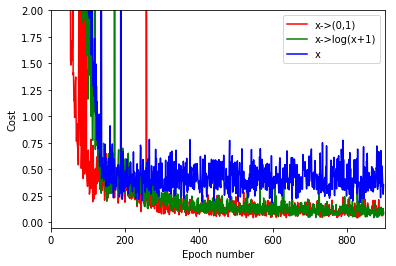

In [68]:
plt.plot(binary.Epoch, binary.cost, color='r')
plt.plot(log.Epoch, log.cost, color='g')
plt.plot(non.Epoch, non.cost, color='b')
plt.xlabel('Epoch number')
plt.ylabel('Cost')
plt.ylim(-0.05, 2)
plt.xlim(0, 905)
plt.legend(('x->(0,1)', 'x->log(x+1)', 'x'))

2) Comparing R^2 from partial data and full dataset

2 hidden layer model, 50 nodes and 25 nodes each

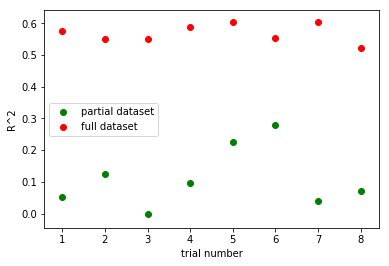

In [74]:
trials = [1, 2, 3, 4, 5, 6, 7, 8]
partial = [0.05283864, 0.12415486, 0.00022403, 0.09502669, 0.22610443, 0.27914648, 0.04014865, 0.07257308]
full = [0.5743373, 0.54912524, 0.55121789, 0.58873684, 0.60274144, 0.55380666, 0.6047694, 0.52323944]
plt.scatter(trials, partial, c='g')
plt.scatter(trials, full, c = 'r')
plt.xlabel('trial number')
plt.ylabel('R^2')
plt.legend(('partial dataset', 'full dataset'))

3) Comparing NNs with different number of nodes in the hidden layer

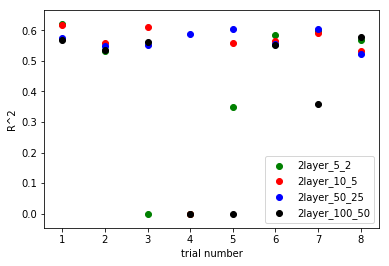

In [86]:
l2_5_2 = [0.61896012,0.53270644,3.06E-31,4.23E-05,0.3485523,0.58375834,0.59753719,0.56718316]
l2_10_5 = [0.61686939,0.55970689,0.61003986,0.00013259,0.55750357,0.56649397,0.59018233,0.53085809]
l2_50_25 = [0.5743373,0.54912524,0.55121789,0.58873684,0.60274144,0.55380666,0.6047694,0.52323944]
l2_100_50 = [0.56976497,0.53703742,0.56213195,3.27E-30,0,0.55265919,0.35860149,0.57682541]

trials = [1, 2, 3, 4, 5, 6, 7, 8]
plt.scatter(trials, l2_5_2, c = 'g')
plt.scatter(trials, l2_10_5, c = 'r')
plt.scatter(trials, l2_50_25, c = 'b')
plt.scatter(trials, l2_100_50, c = 'black')

plt.xlabel('trial number')
plt.ylabel('R^2')
plt.legend(('2layer_5_2', '2layer_10_5', '2layer_50_25', '2layer_100_50'))


4) Observing the local minimum trap of the cost function

In [100]:
l2_1000_500_3500epochs = pd.read_csv('L2-1000-500-3500runs.csv')

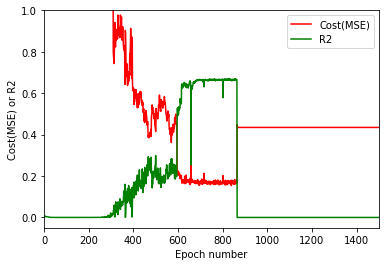

In [104]:
x = l2_1000_500_3500epochs['epoch'].values
y1 = l2_1000_500_3500epochs['mse'].values
y2 = l2_1000_500_3500epochs['r2_plot'].values
plt.plot(x, y1, color ='r')
plt.plot(x, y2, color ='g')
plt.xlabel('Epoch number')
plt.ylabel('Cost(MSE) or R2')
plt.ylim(-0.05, 1)
plt.xlim(0, 1500)
plt.legend(('Cost(MSE)', 'R2'))

### Summary
In conclusion, the optimized NN that gives the highest R2 value has the following characters:
-	All training data and all descriptors are used without any filtering process.
-	Logarithmic transformation of descriptors x and no preprocessing of target y.
-	The NN has two hidden layers. The first and second hidden layers have 50 and 25 neurons respectively.
-	ReLu is used as the activation function for all hidden layers. Linear activation function is used for the output layer.
-	The learning rate is kept at 0.001.
-	Weights and biases are random values from a truncated normal distribution with a mean of 0 and standard deviation of 1. Values who is outside of [-2, 2] are dropped and re-picked.
-	Adam optimizer is used.
-	A dropout rate of 25% is used for all hidden layers and no dropout is used in the output layer.
-	Batch size is 300 and epoch number is 900.

The highest R2 value on the test data (which is 20% split from the training data) is 0.568 +/- 0.027. The Kaggle leadership board shows a top average R2 score of 0.494 for all 15 molecules. Compared to that result, the R2 value from the NN is decent and satisfactory.
